# Test validity partial step 4 : $P(B_f | ...) \propto \eta^t \ \left(\bold{C}_{\rm approx}^{1/2}(\bold{N_{c}}^{-1} + \bold{C}_{\rm approx}^{-1}) \bold{C}_{\rm approx}^{1/2} \right)^{-1} \ \eta$

In [59]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
import jax
from jax import random, dtypes
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import numpyro
import numpyro.distributions as dist

import micmac as micmac

In [60]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# freq_maps is defined there

In [61]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


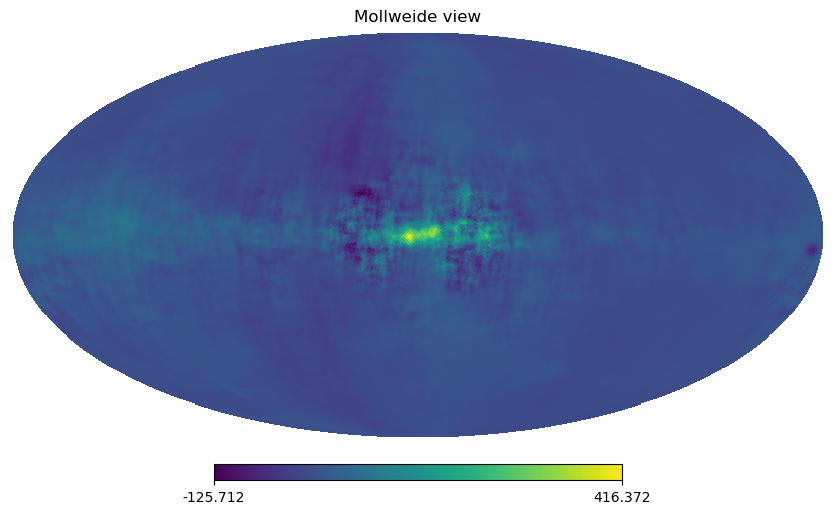

In [62]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [63]:
# working_directory_path = os.path.abspath('') + '/'
working_directory_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_v3/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'

path_toml_file = directory_toml_file + 'test_full_chain_v1a.toml'
path_toml_file = directory_toml_file + 'test_full_chain_v1c.toml'
# path_toml_file = directory_toml_file + 'test_classical_chain_v1a.toml'
path_toml_file = directory_toml_file + 'test_full_chain_v0a.toml'


In [64]:
MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)

In [65]:
reduction_noise = 1
# MICMAC_sampler_obj.r_true = 1

In [66]:
freq_inverse_noise = micmac.get_noise_covar(instrument['depth_p']/reduction_noise, MICMAC_sampler_obj.nside)

In [67]:
instrument = get_instrument(instr_name)

noise_bool = True
# noise_bool = False

instrument['depth_p'] /= reduction_noise
# get input freq maps
np.random.seed(noise_seed+1)
# freq_maps = get_observation(instrument, model, nside=NSIDE, noise=noise)[:, 1:, :]   # keep only Q and U
freq_maps_fgs = get_observation(instrument, fgs_model, nside=MICMAC_sampler_obj.nside, noise=noise_bool)[:, 1:, :]   # keep only Q and U


In [68]:
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_sampler_obj.nstokes]

In [69]:
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), MICMAC_sampler_obj.number_components, pos_special_freqs=[0,-1])
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], MICMAC_sampler_obj.number_components, init_params, pos_special_freqs=[0,-1])

mixing_matrix_sampled = mixing_matrix_obj.get_B()

BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

In [70]:
# input_freq_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)
input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

theoretical_r0_total = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)

# true_cmb_specra = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)
# true_cmb_specra_extended = np.zeros((6,MICMAC_sampler_obj.lmax+1))
# true_cmb_specra_extended[indices_polar,MICMAC_sampler_obj.lmin:] = true_cmb_specra

# input_cmb_maps_alt = hp.synfast(true_cmb_specra_extended, nside=MICMAC_sampler_obj.nside, new=True, lmax=MICMAC_sampler_obj.lmax)[1:,...]

# input_cmb_maps = np.repeat(input_cmb_maps_alt.ravel(order='F'), MICMAC_sampler_obj.number_frequencies).reshape((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix),order='F')

# input_freq_maps = input_cmb_maps + freq_maps_fgs

Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [71]:
s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, input_freq_maps, jax_use=False)[0, :, :]

In [72]:
red_cov_matrix_sample = theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor

red_cov_approx_matrix = np.copy(theoretical_red_cov_r0_total)
c_ell_approx = micmac.get_c_ells_from_red_covariance_matrix(red_cov_approx_matrix)
red_cov_approx_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix)


In [73]:
nstokes = MICMAC_sampler_obj.nstokes
lmin = MICMAC_sampler_obj.lmin
lmax = MICMAC_sampler_obj.lmax
nside = MICMAC_sampler_obj.nside
n_iter = MICMAC_sampler_obj.n_iter

In [74]:
_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, lmax)[0,0,lmin:]
red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

In [75]:
def get_conditional_proba_first_part_JAX(complete_mixing_matrix, _input_freq_maps, suppress_low_modes=False):
    """ Get conditional probability of spectral likelihood by sampling

        The associated conditional probability is given by : 
        - d^t N^{-1} B (B^t N^{-1} B)^{-1} B^t N^{-1} d
    """

    # Building the spectral_likelihood : - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)

    BtinvNB = micmac.get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix, jax_use=True)#*jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    BtinvN = micmac.get_BtinvN(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix, jax_use=True)#/jhp.nside2resol(MICMAC_sampler_obj.nside)**2

    full_data_without_CMB_with_noise = jnp.einsum('cf,fsp->csp', BtinvN, _input_freq_maps)
    if suppress_low_modes:
        covariance_unity = jnp.zeros((MICMAC_sampler_obj.lmax+1-MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.nstokes))
        # covariance_unity = covariance_unity.at[lmin:,...].set(jnp.eye(nstokes))
        covariance_unity = covariance_unity.at[:,...].set(jnp.eye(MICMAC_sampler_obj.nstokes))
        for i in range(MICMAC_sampler_obj.number_components-1):
            full_data_without_CMB_with_noise = full_data_without_CMB_with_noise.at[i].set(micmac.maps_x_red_covariance_cell_JAX(jnp.copy(full_data_without_CMB_with_noise[i]), covariance_unity, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter))

    first_term_complete = jnp.einsum('psc,cm,msp', full_data_without_CMB_with_noise.T, BtinvNB, full_data_without_CMB_with_noise)
    return -(-first_term_complete + 0)/2.

def get_conditional_proba_second_part_JAX(complete_mixing_matrix, _input_freq_maps, red_cov_matrix):

    s_c_ML = micmac.get_Wd(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix, _input_freq_maps, jax_use=True)[0, :, :]#/jhp.nside2resol(MICMAC_sampler_obj.nside)**2

    # new_BtinvNB = micmac.get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix, jax_use=True)
    # cl_noise_harmonic = new_BtinvNB[0,0]*jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    cl_noise_harmonic = micmac.get_Cl_noise_JAX(np.array(instrument['depth_p']), complete_mixing_matrix, MICMAC_sampler_obj.lmax)[0,0,MICMAC_sampler_obj.lmin:]
    red_cl_noise_harmonic = micmac.get_reduced_matrix_from_c_ell_jax(jnp.array([cl_noise_harmonic,cl_noise_harmonic,jnp.zeros_like(cl_noise_harmonic)]))

    harmonic_operator = jnp.linalg.pinv(red_cov_matrix + red_cl_noise_harmonic)
    first_term = micmac.maps_x_red_covariance_cell_JAX(s_c_ML, harmonic_operator, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

    return -jnp.einsum('sp,sp', s_c_ML, first_term)/2.

def get_conditional_proba_third_part_JAX(complete_mixing_matrix, red_cov_matrix):
    """ Get conditional probability of perturbation likelihood by computing it directly in harmonic space

        The associated conditional probability is given by :
    """

    # new_BtinvNB = micmac.get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix, jax_use=True)
    # cl_noise_harmonic = new_BtinvNB[0,0]*jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    # _cl_noise_harm = new_BtinvNB[0,0]*jhp.nside2resol(self.nside)**2
    cl_noise_harmonic = micmac.get_Cl_noise_JAX(jnp.array(instrument['depth_p']), complete_mixing_matrix, MICMAC_sampler_obj.lmax)[0,0,MICMAC_sampler_obj.lmin:]
    red_cl_noise_harm_CMB = micmac.get_reduced_matrix_from_c_ell_jax(jnp.array([cl_noise_harmonic,cl_noise_harmonic,jnp.zeros_like(cl_noise_harmonic)]))


    red_operator_term = red_cov_matrix + red_cl_noise_harm_CMB

    log_det_correction = ( (2*jnp.arange(MICMAC_sampler_obj.lmin, MICMAC_sampler_obj.lmax+1) +1) * jnp.log(jnp.linalg.det(red_operator_term)) ).sum()

    return -log_det_correction/2.

def get_conditional_proba_fourth_part_JAX(complete_mixing_matrix, red_cov_approx_matrix):
    """ Get conditional probability of perturbation likelihood by computing it directly in harmonic space

        The associated conditional probability is given by :
    """

    # new_BtinvNB = micmac.get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix, jax_use=True)
    # cl_noise_harmonic = new_BtinvNB[0,0]*jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    cl_noise_harmonic = micmac.get_Cl_noise_JAX(jnp.array(instrument['depth_p']), complete_mixing_matrix, MICMAC_sampler_obj.lmax)[0,0,MICMAC_sampler_obj.lmin:]
    red_cl_noise_harm_CMB = micmac.get_reduced_matrix_from_c_ell_jax(jnp.array([cl_noise_harmonic,cl_noise_harmonic,jnp.zeros_like(cl_noise_harmonic)]))

    red_operator_term = jnp.linalg.pinv(red_cov_approx_matrix + red_cl_noise_harm_CMB)

    log_det_correction = ( (2*jnp.arange(MICMAC_sampler_obj.lmin, MICMAC_sampler_obj.lmax+1) +1) * jnp.log(jnp.linalg.det(red_operator_term)) ).sum()

    return -log_det_correction/2.


def get_alternative_sampling_r_B_f(all_params, _input_freq_maps, red_cov_approx_matrix):
    """ Get alternative sampling B_f with proper marginalization over s_c
    """

    new_params_mixing_matrix = all_params[:-1]
    r_value = all_params[-1]

    params_mixing_matrix = jnp.copy(new_params_mixing_matrix)
    red_cov_matrix = theoretical_red_cov_r0_total + r_value * theoretical_red_cov_r1_tensor

    # new_mixing_matrix = create_mixing_matrix_jax(params_mixing_matrix, self.number_components, self.number_frequencies, pos_special_freqs=self.pos_special_freqs)
    MICMAC_sampler_obj._fake_mixing_matrix.update_params(params_mixing_matrix.reshape((MICMAC_sampler_obj.number_frequencies-jnp.size(MICMAC_sampler_obj.pos_special_freqs), MICMAC_sampler_obj.number_components-1),order='F'),jax_use=True)
    new_mixing_matrix = MICMAC_sampler_obj._fake_mixing_matrix.get_B(jax_use=True)
    
    factor_norm = jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    # factor_norm = 1/MICMAC_sampler_obj.npix
    log_proba_first_term = get_conditional_proba_first_part_JAX(new_mixing_matrix, _input_freq_maps, suppress_low_modes=True)*factor_norm
    log_proba_second_term = get_conditional_proba_second_part_JAX(new_mixing_matrix, _input_freq_maps, red_cov_matrix)*factor_norm #jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    log_proba_third_term = get_conditional_proba_third_part_JAX(new_mixing_matrix, red_cov_matrix)
    log_proba_fourth_term = get_conditional_proba_fourth_part_JAX(new_mixing_matrix, red_cov_approx_matrix)

    return -(log_proba_first_term + log_proba_second_term + log_proba_third_term + log_proba_fourth_term)

def get_alternative_sampling_r_B_f_wo_corr(all_params, _input_freq_maps, red_cov_approx_matrix):
    """ Get alternative sampling B_f with proper marginalization over s_c
    """
    new_params_mixing_matrix = all_params[:-1]
    r_value = all_params[-1]

    params_mixing_matrix = jnp.copy(new_params_mixing_matrix)
    red_cov_matrix = theoretical_red_cov_r0_total + r_value * theoretical_red_cov_r1_tensor

    # new_mixing_matrix = create_mixing_matrix_jax(params_mixing_matrix, self.number_components, self.number_frequencies, pos_special_freqs=self.pos_special_freqs)
    MICMAC_sampler_obj._fake_mixing_matrix.update_params(params_mixing_matrix.reshape((MICMAC_sampler_obj.number_frequencies-jnp.size(MICMAC_sampler_obj.pos_special_freqs), MICMAC_sampler_obj.number_components-1),order='F'),jax_use=True)
    new_mixing_matrix = MICMAC_sampler_obj._fake_mixing_matrix.get_B(jax_use=True)
    
    factor_norm = jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    # factor_norm = 1/MICMAC_sampler_obj.npix
    log_proba_first_term = get_conditional_proba_first_part_JAX(new_mixing_matrix, _input_freq_maps, suppress_low_modes=True)*factor_norm #jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    log_proba_second_term = get_conditional_proba_second_part_JAX(new_mixing_matrix, _input_freq_maps, red_cov_matrix)*factor_norm #jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    log_proba_third_term = get_conditional_proba_third_part_JAX(new_mixing_matrix, red_cov_matrix)
    # log_proba_fourth_term = get_conditional_proba_fourth_part_JAX(new_mixing_matrix, red_cov_approx_matrix)

    return -(log_proba_first_term + log_proba_second_term + log_proba_third_term) #+ log_proba_fourth_term

def get_alternative_sampling_r_B_f_only_corr(all_params, _input_freq_maps, red_cov_approx_matrix):
    """ Get alternative sampling B_f with proper marginalization over s_c
    """
    new_params_mixing_matrix = all_params[:-1]
    r_value = all_params[-1]

    params_mixing_matrix = jnp.copy(new_params_mixing_matrix)
    red_cov_matrix = theoretical_red_cov_r0_total + r_value * theoretical_red_cov_r1_tensor

    # new_mixing_matrix = create_mixing_matrix_jax(params_mixing_matrix, self.number_components, self.number_frequencies, pos_special_freqs=self.pos_special_freqs)
    MICMAC_sampler_obj._fake_mixing_matrix.update_params(params_mixing_matrix.reshape((MICMAC_sampler_obj.number_frequencies-jnp.size(MICMAC_sampler_obj.pos_special_freqs), MICMAC_sampler_obj.number_components-1),order='F'),jax_use=True)
    new_mixing_matrix = MICMAC_sampler_obj._fake_mixing_matrix.get_B(jax_use=True)
    
    # log_proba_first_term = get_conditional_proba_first_part_JAX(new_mixing_matrix, _input_freq_maps, suppress_low_modes=True)
    # log_proba_second_term = get_conditional_proba_second_part_JAX(new_mixing_matrix, _input_freq_maps, red_cov_matrix)
    # log_proba_third_term = get_conditional_proba_third_part_JAX(new_mixing_matrix, red_cov_matrix)
    log_proba_fourth_term = get_conditional_proba_fourth_part_JAX(new_mixing_matrix, red_cov_approx_matrix)

    return -log_proba_fourth_term

In [76]:
jhp.nside2resol(MICMAC_sampler_obj.nside)**2

0.0002556634646476069

In [77]:
4*jnp.pi/MICMAC_sampler_obj.npix

0.00025566346464760684

In [78]:
first_guess_B_f = jnp.ravel(init_params, order='F')
first_guess_0 = jnp.zeros(first_guess_B_f.size+1)

first_guess_0 = first_guess_0.at[:-1].set(first_guess_B_f)
first_guess_0 = first_guess_0.at[-1].set(MICMAC_sampler_obj.r_true)

In [79]:
min_prop = .9
max_prop = 1.1

min_prop = .99
max_prop = 1.01

bounds = np.array([min_prop*first_guess_0, max_prop*first_guess_0]).T
first_guess = first_guess_0*np.random.uniform(low=min_prop, high=max_prop, size=first_guess_0.size)
# first_guess = first_guess.at[-1].set(MICMAC_sampler_obj.r_true*np.random.uniform(low=.999, high=1.001))
first_guess = first_guess.at[-1].set(MICMAC_sampler_obj.r_true*np.random.uniform(low=.5, high=2))

In [80]:
# first_guess = jnp.array([0.33889809, 0.02964221, 0.00997896, 0.00328953, 0.00980191, 0.05151063, 0.12920801, 0.44065359, 0.01591372])
# first_guess = jnp.array([0.33889809, 0.02964221, 0.00997896, 0.00328953, 0.00980191, 0.05151063, 0.12920801, 0.44065359, 0.01591372])

In [81]:
for index in [-3,-2]:
    bounds[index] = np.array([.995*first_guess_0[index],1.005*first_guess_0[index]])
for index in [1,2,5]:
    bounds[index] = np.array([.95*first_guess_0[index],1.05*first_guess_0[index]])

for index in [3]:
    bounds[index] = np.array([.5*first_guess_0[index],1.5*first_guess_0[index]])
for index in [4]:
    bounds[index] = np.array([.8*first_guess_0[index],1.2*first_guess_0[index]])

In [82]:
# bounds[-1] = np.array([.8*MICMAC_sampler_obj.r_true,1.2*MICMAC_sampler_obj.r_true])
if MICMAC_sampler_obj.r_true > 0:
    bounds[-1] = np.array([.5*MICMAC_sampler_obj.r_true,2*MICMAC_sampler_obj.r_true])
else:
    bounds[-1] = np.array([-.01,.01])

In [83]:
init_params.ravel(order='F')

array([0.33858815, 0.02963068, 0.00998213, 0.00328725, 0.00979233,
       0.05147511, 0.12913911, 0.44076761])

In [84]:
bounds

array([[ 0.33520226,  0.34197403],
       [ 0.02814915,  0.03111221],
       [ 0.00948302,  0.01048123],
       [ 0.00164363,  0.00493088],
       [ 0.00783387,  0.0117508 ],
       [ 0.04890136,  0.05404887],
       [ 0.12849342,  0.12978481],
       [ 0.43856378,  0.44297145],
       [-0.01      ,  0.01      ]])

In [85]:
first_guess, first_guess_0

(Array([0.34070924, 0.02986351, 0.01005394, 0.00330034, 0.00971962,
        0.05103734, 0.12989169, 0.43980471, 0.        ], dtype=float64),
 Array([0.33858815, 0.02963068, 0.00998213, 0.00328725, 0.00979233,
        0.05147511, 0.12913911, 0.44076761, 0.        ], dtype=float64))

In [86]:
%%time
result_unbiased = scipy.optimize.minimize(get_alternative_sampling_r_B_f, first_guess, bounds=bounds, args=(input_freq_maps, red_cov_approx_matrix))

CPU times: user 22min 40s, sys: 6min 30s, total: 29min 10s
Wall time: 5min 10s


In [87]:
result_unbiased

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -587826.412987019
        x: [ 3.409e-01  2.990e-02  9.483e-03  1.644e-03  1.033e-02
             5.151e-02  1.292e-01  4.412e-01  4.684e-05]
      nit: 30
      jac: [-8.197e+01  4.335e+01  9.166e+03  1.336e+04 -4.295e+02
             1.003e+03  5.613e+02  1.253e+02 -6.430e+01]
     nfev: 360
     njev: 36
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>

In [88]:
get_alternative_sampling_r_B_f(result_unbiased.x, input_freq_maps, red_cov_approx_matrix),get_alternative_sampling_r_B_f(first_guess_0, input_freq_maps, red_cov_approx_matrix)

(Array(-587826.41298702, dtype=float64),
 Array(-587795.23009642, dtype=float64))

In [89]:
# get_alternative_sampling_r_B_f(result_biased.x, input_freq_maps, red_cov_approx_matrix)

In [90]:
%%time
result_biased = scipy.optimize.minimize(get_alternative_sampling_r_B_f_wo_corr, first_guess, bounds=bounds, args=(input_freq_maps, red_cov_approx_matrix))

CPU times: user 22min 22s, sys: 5min 32s, total: 27min 54s
Wall time: 4min 31s


In [91]:
result_biased

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -760524.0978449588
        x: [ 3.408e-01  2.981e-02  9.483e-03  1.644e-03  1.034e-02
             5.152e-02  1.292e-01  4.412e-01  6.627e-05]
      nit: 28
      jac: [-7.001e+01 -1.853e+02  9.038e+03  1.334e+04 -3.993e+02
            -5.790e+02 -2.783e+02  2.875e+02  1.012e+02]
     nfev: 330
     njev: 33
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>

In [92]:
init_params

array([[0.33858815, 0.00979233],
       [0.02963068, 0.05147511],
       [0.00998213, 0.12913911],
       [0.00328725, 0.44076761]])